# Resampling Methods

Implementation of resampling techniques for model validation and uncertainty estimation.

## Contents
1. Train/Test Split Validation
2. Leave-One-Out Cross-Validation (LOOCV)
3. K-Fold Cross-Validation
4. Bootstrap for Parameter Estimation
5. Bootstrap for Model Coefficient Uncertainty

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set random seed for reproducibility
np.random.seed(1)

## Load Auto Dataset

In [2]:
# Load Auto dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
Auto = pd.read_csv(url, sep='\s+', names=column_names, na_values='?')
Auto = Auto.dropna()

# Convert horsepower to numeric
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'])

print(f"Dataset shape: {Auto.shape}")
print(f"\nFirst few rows:")
Auto.head()

Dataset shape: (392, 9)

First few rows:


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## 1. Simple Train/Test Split Validation

Split data into training (50%) and testing (50%) sets.

In [3]:
# Set seed for reproducibility
np.random.seed(1)

# Prepare data
X = Auto[['horsepower']]
y = Auto['mpg']

# Split: 50% train, 50% test (same as R: train=sample(392,196))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 196
Test set size: 196


### Linear Model (Degree 1)

In [4]:
# Fit linear model
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Predict on test set
y_pred = model_linear.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_linear = mean_squared_error(y_test, y_pred)

print(f"Linear Model (degree 1)")
print(f"Test MSE: {mse_linear:.4f}")

Linear Model (degree 1)
Test MSE: 24.8021


### Polynomial Models (Degree 2 and 3)

In [5]:
# Polynomial degree 2
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.transform(X_test)

model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)
y_pred_poly2 = model_poly2.predict(X_test_poly2)
mse_poly2 = mean_squared_error(y_test, y_pred_poly2)

print(f"Polynomial Model (degree 2)")
print(f"Test MSE: {mse_poly2:.4f}")

# Polynomial degree 3
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3 = poly3.fit_transform(X_train)
X_test_poly3 = poly3.transform(X_test)

model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)
y_pred_poly3 = model_poly3.predict(X_test_poly3)
mse_poly3 = mean_squared_error(y_test, y_pred_poly3)

print(f"\nPolynomial Model (degree 3)")
print(f"Test MSE: {mse_poly3:.4f}")

Polynomial Model (degree 2)
Test MSE: 18.8483

Polynomial Model (degree 3)
Test MSE: 18.8051


In [6]:
# Compare models
results_train_test = pd.DataFrame({
    'Model': ['Linear', 'Polynomial (deg 2)', 'Polynomial (deg 3)'],
    'Test MSE': [mse_linear, mse_poly2, mse_poly3]
})

print("\n" + "="*50)
print("TRAIN/TEST SPLIT VALIDATION RESULTS")
print("="*50)
print(results_train_test)
print("="*50)
print("\nNote: Results depend on the random train/test split!")


TRAIN/TEST SPLIT VALIDATION RESULTS
                Model   Test MSE
0              Linear  24.802121
1  Polynomial (deg 2)  18.848293
2  Polynomial (deg 3)  18.805111

Note: Results depend on the random train/test split!


### Effect of Different Random Seeds

In [7]:
# Try different random seeds to show variability
seeds = [1, 2, 3, 4, 5]
results_by_seed = []

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
    
    # Linear
    model = LinearRegression()
    model.fit(X_train, y_train)
    mse_lin = mean_squared_error(y_test, model.predict(X_test))
    
    # Polynomial degree 2
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    model.fit(X_train_poly, y_train)
    mse_poly = mean_squared_error(y_test, model.predict(X_test_poly))
    
    results_by_seed.append({'Seed': seed, 'Linear MSE': mse_lin, 'Poly2 MSE': mse_poly})

df_seeds = pd.DataFrame(results_by_seed)
print("\nTest MSE with Different Random Seeds:")
print(df_seeds)
print(f"\nLinear MSE: mean={df_seeds['Linear MSE'].mean():.2f}, std={df_seeds['Linear MSE'].std():.2f}")
print(f"Poly2 MSE: mean={df_seeds['Poly2 MSE'].mean():.2f}, std={df_seeds['Poly2 MSE'].std():.2f}")
print("\n→ Results vary based on train/test split! Need better validation method.")


Test MSE with Different Random Seeds:
   Seed  Linear MSE  Poly2 MSE
0     1   24.802121  18.848293
1     2   23.442644  18.550199
2     3   20.755408  16.945107
3     4   25.313382  20.644036
4     5   29.588635  24.147272

Linear MSE: mean=24.78, std=3.22
Poly2 MSE: mean=19.83, std=2.75

→ Results vary based on train/test split! Need better validation method.


## 2. Leave-One-Out Cross-Validation (LOOCV)

Train on n-1 observations, test on 1 observation. Repeat n times.

In [8]:
# LOOCV for linear model
loo = LeaveOneOut()
model = LinearRegression()

# Perform LOOCV
mse_scores = []
for train_idx, test_idx in loo.split(X):
    X_train_loo, X_test_loo = X.iloc[train_idx], X.iloc[test_idx]
    y_train_loo, y_test_loo = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train_loo, y_train_loo)
    y_pred_loo = model.predict(X_test_loo)
    mse_scores.append(mean_squared_error(y_test_loo, y_pred_loo))

loocv_mse = np.mean(mse_scores)
print(f"LOOCV MSE (Linear): {loocv_mse:.4f}")
print(f"Number of iterations: {len(mse_scores)}")

LOOCV MSE (Linear): 24.2315
Number of iterations: 392


### LOOCV for Polynomial Models (Degrees 1-5)

In [9]:
# Compute LOOCV error for polynomial models of degree 1 to 5
loocv_errors = []

for degree in range(1, 6):
    print(f"Computing LOOCV for degree {degree}...", end=' ')
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    mse_scores = []
    for train_idx, test_idx in loo.split(X_poly):
        X_train_loo = X_poly[train_idx]
        X_test_loo = X_poly[test_idx]
        y_train_loo = y.iloc[train_idx]
        y_test_loo = y.iloc[test_idx]
        
        model.fit(X_train_loo, y_train_loo)
        y_pred_loo = model.predict(X_test_loo)
        mse_scores.append(mean_squared_error(y_test_loo, y_pred_loo))
    
    loocv_mse = np.mean(mse_scores)
    loocv_errors.append(loocv_mse)
    print(f"MSE = {loocv_mse:.4f}")

# Display results
loocv_results = pd.DataFrame({
    'Degree': range(1, 6),
    'LOOCV MSE': loocv_errors
})

print("\n" + "="*50)
print("LOOCV RESULTS")
print("="*50)
print(loocv_results)
print("="*50)

Computing LOOCV for degree 1... MSE = 24.2315
Computing LOOCV for degree 2... MSE = 19.2482
Computing LOOCV for degree 3... MSE = 19.3350
Computing LOOCV for degree 4... MSE = 19.4244
Computing LOOCV for degree 5... MSE = 19.0332

LOOCV RESULTS
   Degree  LOOCV MSE
0       1  24.231514
1       2  19.248213
2       3  19.334984
3       4  19.424430
4       5  19.033214


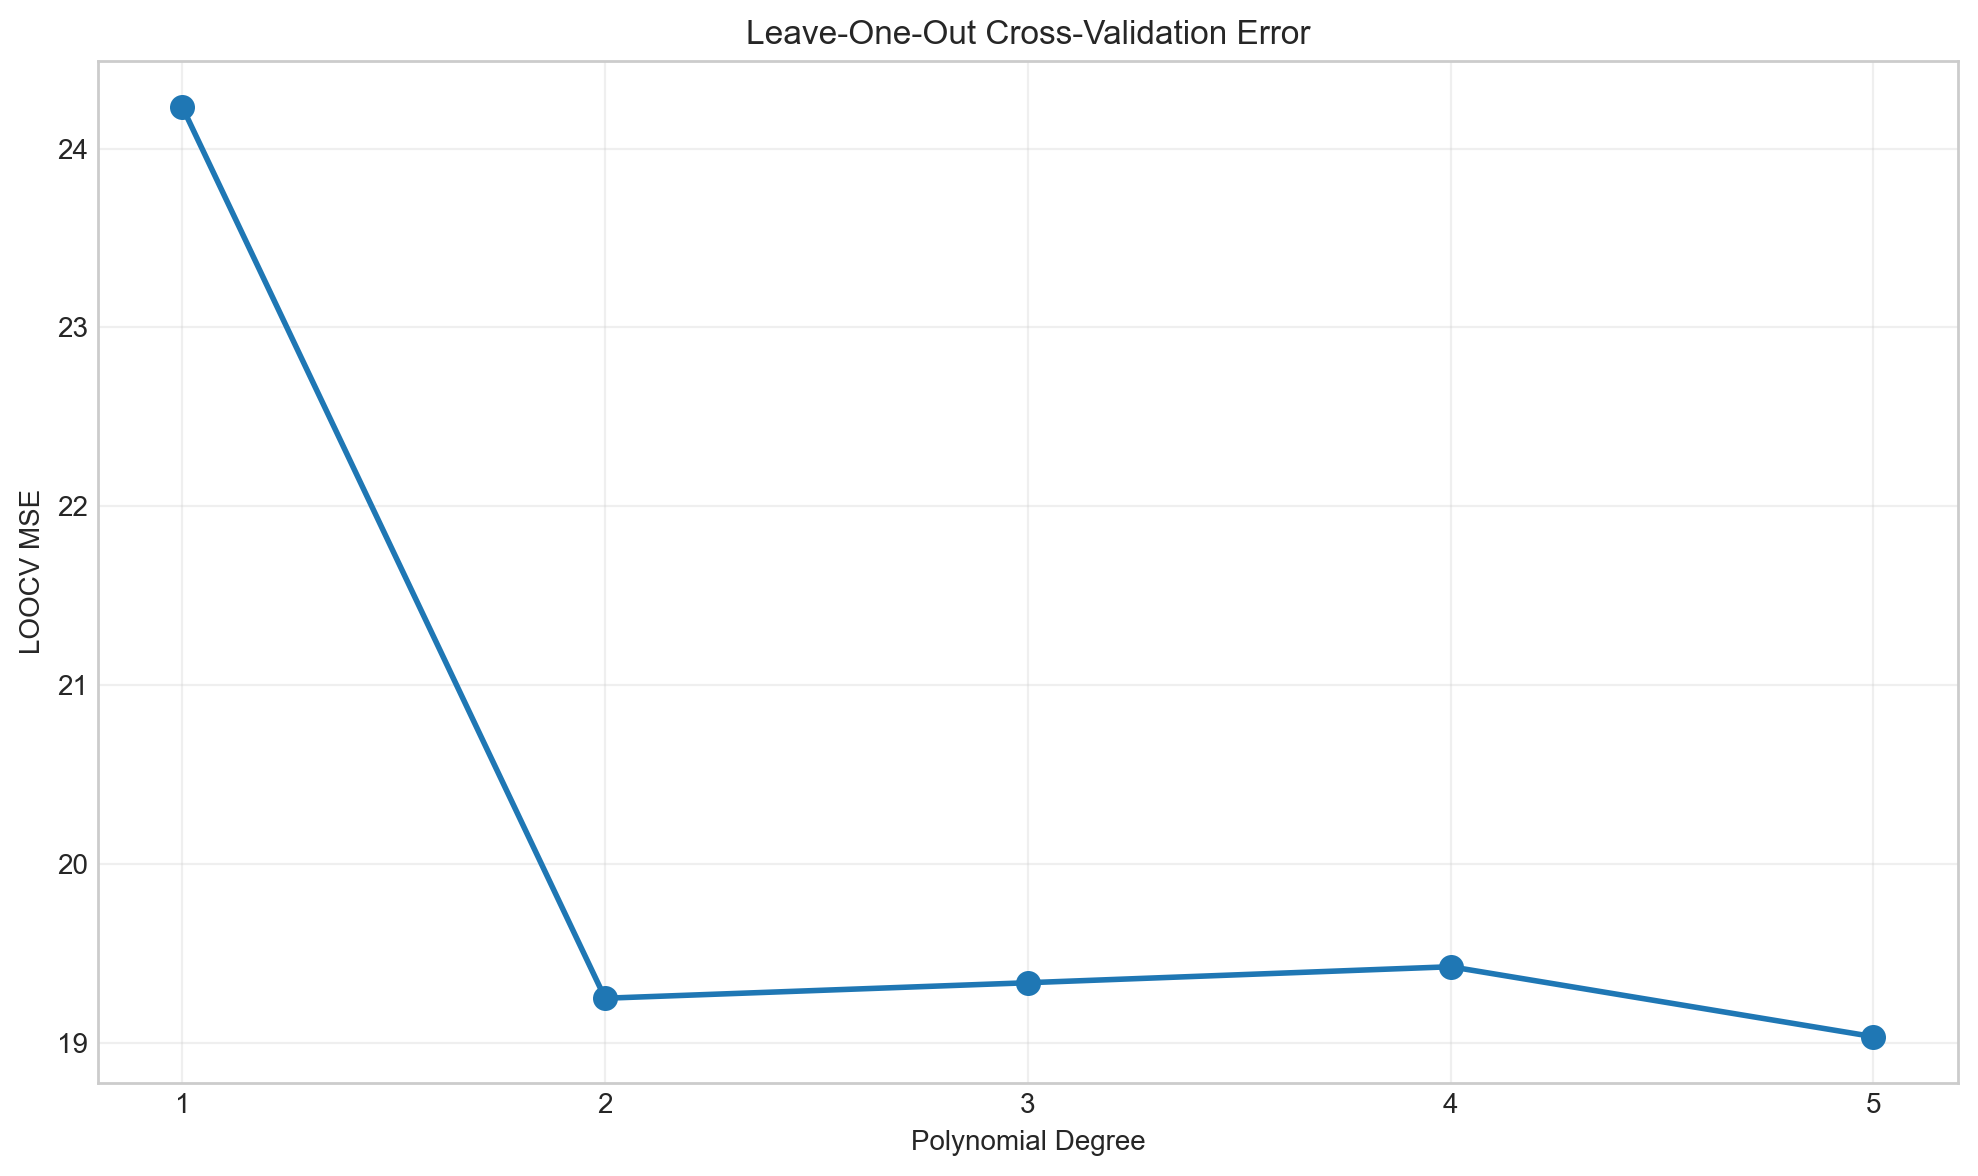


Best degree: 5
Lowest MSE: 19.0332


In [10]:
# Visualize LOOCV errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), loocv_errors, marker='o', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree')
plt.ylabel('LOOCV MSE')
plt.title('Leave-One-Out Cross-Validation Error')
plt.xticks(range(1, 6))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest degree: {loocv_results.loc[loocv_results['LOOCV MSE'].idxmin(), 'Degree']:.0f}")
print(f"Lowest MSE: {loocv_results['LOOCV MSE'].min():.4f}")

## 3. K-Fold Cross-Validation

Divide data into K folds. Train on K-1 folds, test on 1 fold. Repeat K times.

In [11]:
# Set seed
np.random.seed(17)

# 10-Fold Cross-Validation for polynomial models
kfold_errors = []
kf = KFold(n_splits=10, shuffle=True, random_state=17)

for degree in range(1, 11):
    print(f"Computing 10-Fold CV for degree {degree}...", end=' ')
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Use sklearn's cross_val_score
    model = LinearRegression()
    
    # cross_val_score returns negative MSE, so we negate it
    scores = cross_val_score(model, X_poly, y, cv=kf, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    
    kfold_errors.append(mse)
    print(f"MSE = {mse:.4f}")

# Display results
kfold_results = pd.DataFrame({
    'Degree': range(1, 11),
    '10-Fold CV MSE': kfold_errors
})

print("\n" + "="*50)
print("10-FOLD CROSS-VALIDATION RESULTS")
print("="*50)
print(kfold_results)
print("="*50)

Computing 10-Fold CV for degree 1... MSE = 24.1823
Computing 10-Fold CV for degree 2... MSE = 19.1376
Computing 10-Fold CV for degree 3... MSE = 19.1552
Computing 10-Fold CV for degree 4... MSE = 19.2502
Computing 10-Fold CV for degree 5... MSE = 18.8971
Computing 10-Fold CV for degree 6... MSE = 19.0255
Computing 10-Fold CV for degree 7... MSE = 18.9791
Computing 10-Fold CV for degree 8... MSE = 18.8582
Computing 10-Fold CV for degree 9... MSE = 19.0099
Computing 10-Fold CV for degree 10... MSE = 19.7377

10-FOLD CROSS-VALIDATION RESULTS
   Degree  10-Fold CV MSE
0       1       24.182336
1       2       19.137585
2       3       19.155247
3       4       19.250163
4       5       18.897087
5       6       19.025492
6       7       18.979113
7       8       18.858223
8       9       19.009893
9      10       19.737722


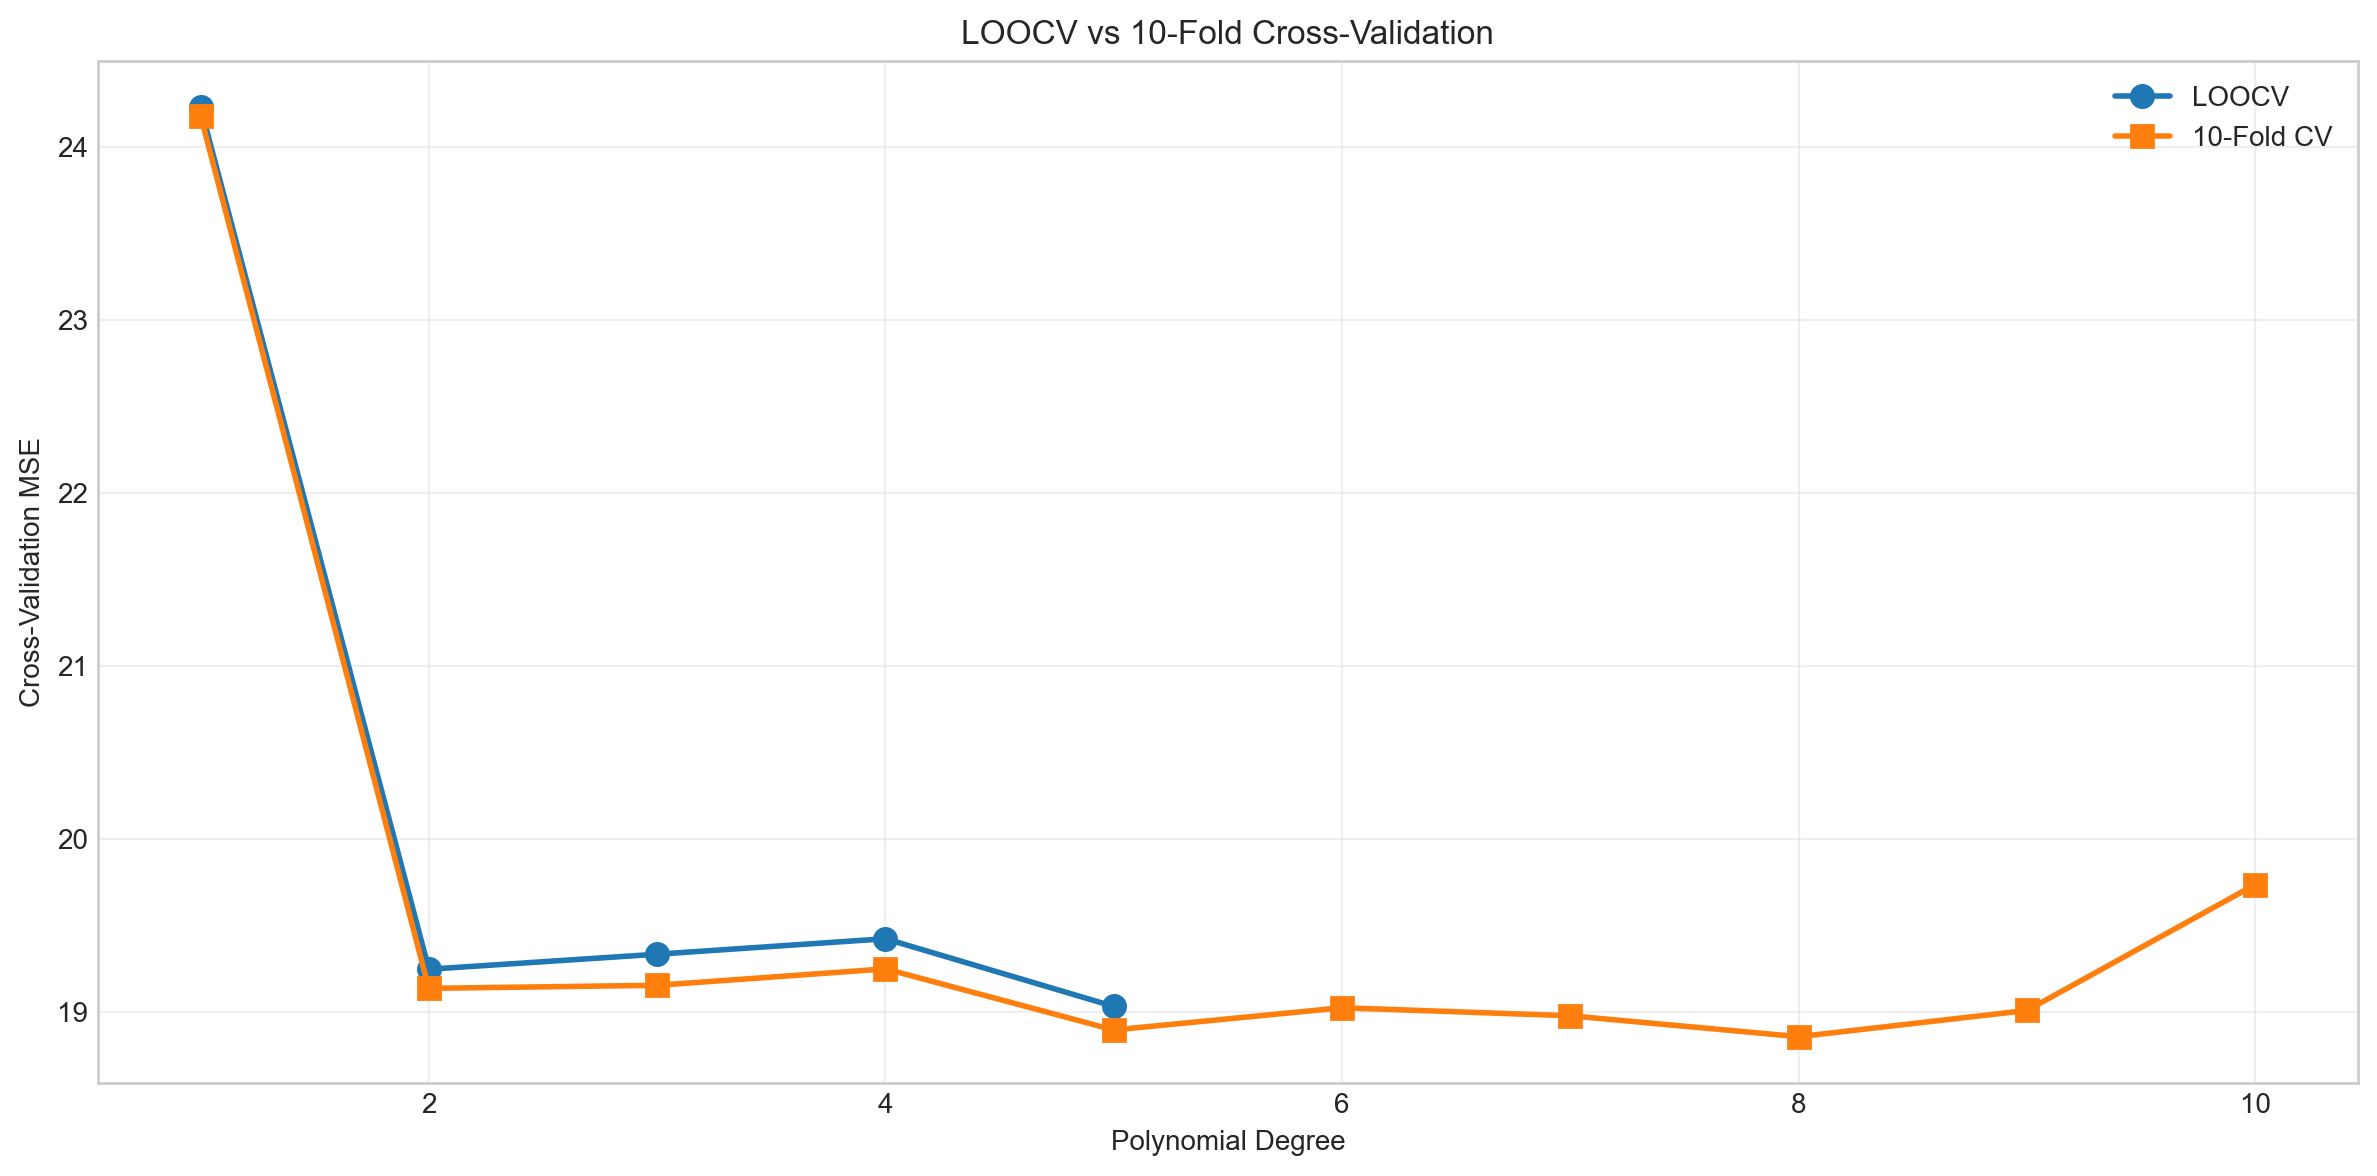


Best degree (10-Fold): 8
Lowest MSE: 18.8582


In [12]:
# Compare LOOCV vs 10-Fold CV
plt.figure(figsize=(12, 6))

plt.plot(range(1, 6), loocv_errors, marker='o', linewidth=2, markersize=8, label='LOOCV')
plt.plot(range(1, 11), kfold_errors, marker='s', linewidth=2, markersize=8, label='10-Fold CV')

plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validation MSE')
plt.title('LOOCV vs 10-Fold Cross-Validation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest degree (10-Fold): {kfold_results.loc[kfold_results['10-Fold CV MSE'].idxmin(), 'Degree']:.0f}")
print(f"Lowest MSE: {kfold_results['10-Fold CV MSE'].min():.4f}")

## 4. Bootstrap

Resample data with replacement to estimate parameter uncertainty.

### Bootstrap for Alpha (Portfolio Dataset)

In [13]:
# Load Portfolio dataset
url_portfolio = "https://raw.githubusercontent.com/selva86/datasets/master/Portfolio.csv"
try:
    Portfolio = pd.read_csv(url_portfolio)
    print(f"Portfolio dataset shape: {Portfolio.shape}")
    Portfolio.head()
except:
    # Create synthetic data if loading fails
    np.random.seed(1)
    Portfolio = pd.DataFrame({
        'X': np.random.randn(100),
        'Y': np.random.randn(100)
    })
    print("Using synthetic Portfolio data")

Using synthetic Portfolio data


In [14]:
# Alpha function: estimates optimal allocation between two investments
def alpha_fn(data, indices):
    """
    Estimate alpha: optimal fraction to invest in asset X vs Y.
    
    Formula: alpha = (var(Y) - cov(X,Y)) / (var(X) + var(Y) - 2*cov(X,Y))
    """
    X = data['X'].iloc[indices]
    Y = data['Y'].iloc[indices]
    
    var_X = np.var(X, ddof=1)
    var_Y = np.var(Y, ddof=1)
    cov_XY = np.cov(X, Y)[0, 1]
    
    alpha = (var_Y - cov_XY) / (var_X + var_Y - 2 * cov_XY)
    return alpha

# Estimate alpha on full dataset
alpha_full = alpha_fn(Portfolio, range(len(Portfolio)))
print(f"Alpha estimate (full dataset): {alpha_full:.4f}")

Alpha estimate (full dataset): 0.5283


In [15]:
# Estimate alpha on a bootstrap sample
np.random.seed(1)
boot_indices = np.random.choice(len(Portfolio), size=len(Portfolio), replace=True)
alpha_boot = alpha_fn(Portfolio, boot_indices)
print(f"Alpha estimate (bootstrap sample): {alpha_boot:.4f}")

Alpha estimate (bootstrap sample): 0.5277


### Perform 1000 Bootstrap Replications

In [16]:
# Bootstrap with 1000 replications
np.random.seed(1)
n_bootstrap = 1000
alpha_estimates = []

for i in range(n_bootstrap):
    boot_indices = np.random.choice(len(Portfolio), size=len(Portfolio), replace=True)
    alpha = alpha_fn(Portfolio, boot_indices)
    alpha_estimates.append(alpha)

alpha_estimates = np.array(alpha_estimates)

# Bootstrap statistics
alpha_mean = np.mean(alpha_estimates)
alpha_std = np.std(alpha_estimates, ddof=1)

print("="*50)
print("BOOTSTRAP RESULTS FOR ALPHA")
print("="*50)
print(f"Original estimate: {alpha_full:.4f}")
print(f"Bootstrap mean: {alpha_mean:.4f}")
print(f"Bootstrap SE: {alpha_std:.4f}")
print(f"Number of replications: {n_bootstrap}")
print("="*50)

BOOTSTRAP RESULTS FOR ALPHA
Original estimate: 0.5283
Bootstrap mean: 0.5280
Bootstrap SE: 0.0570
Number of replications: 1000


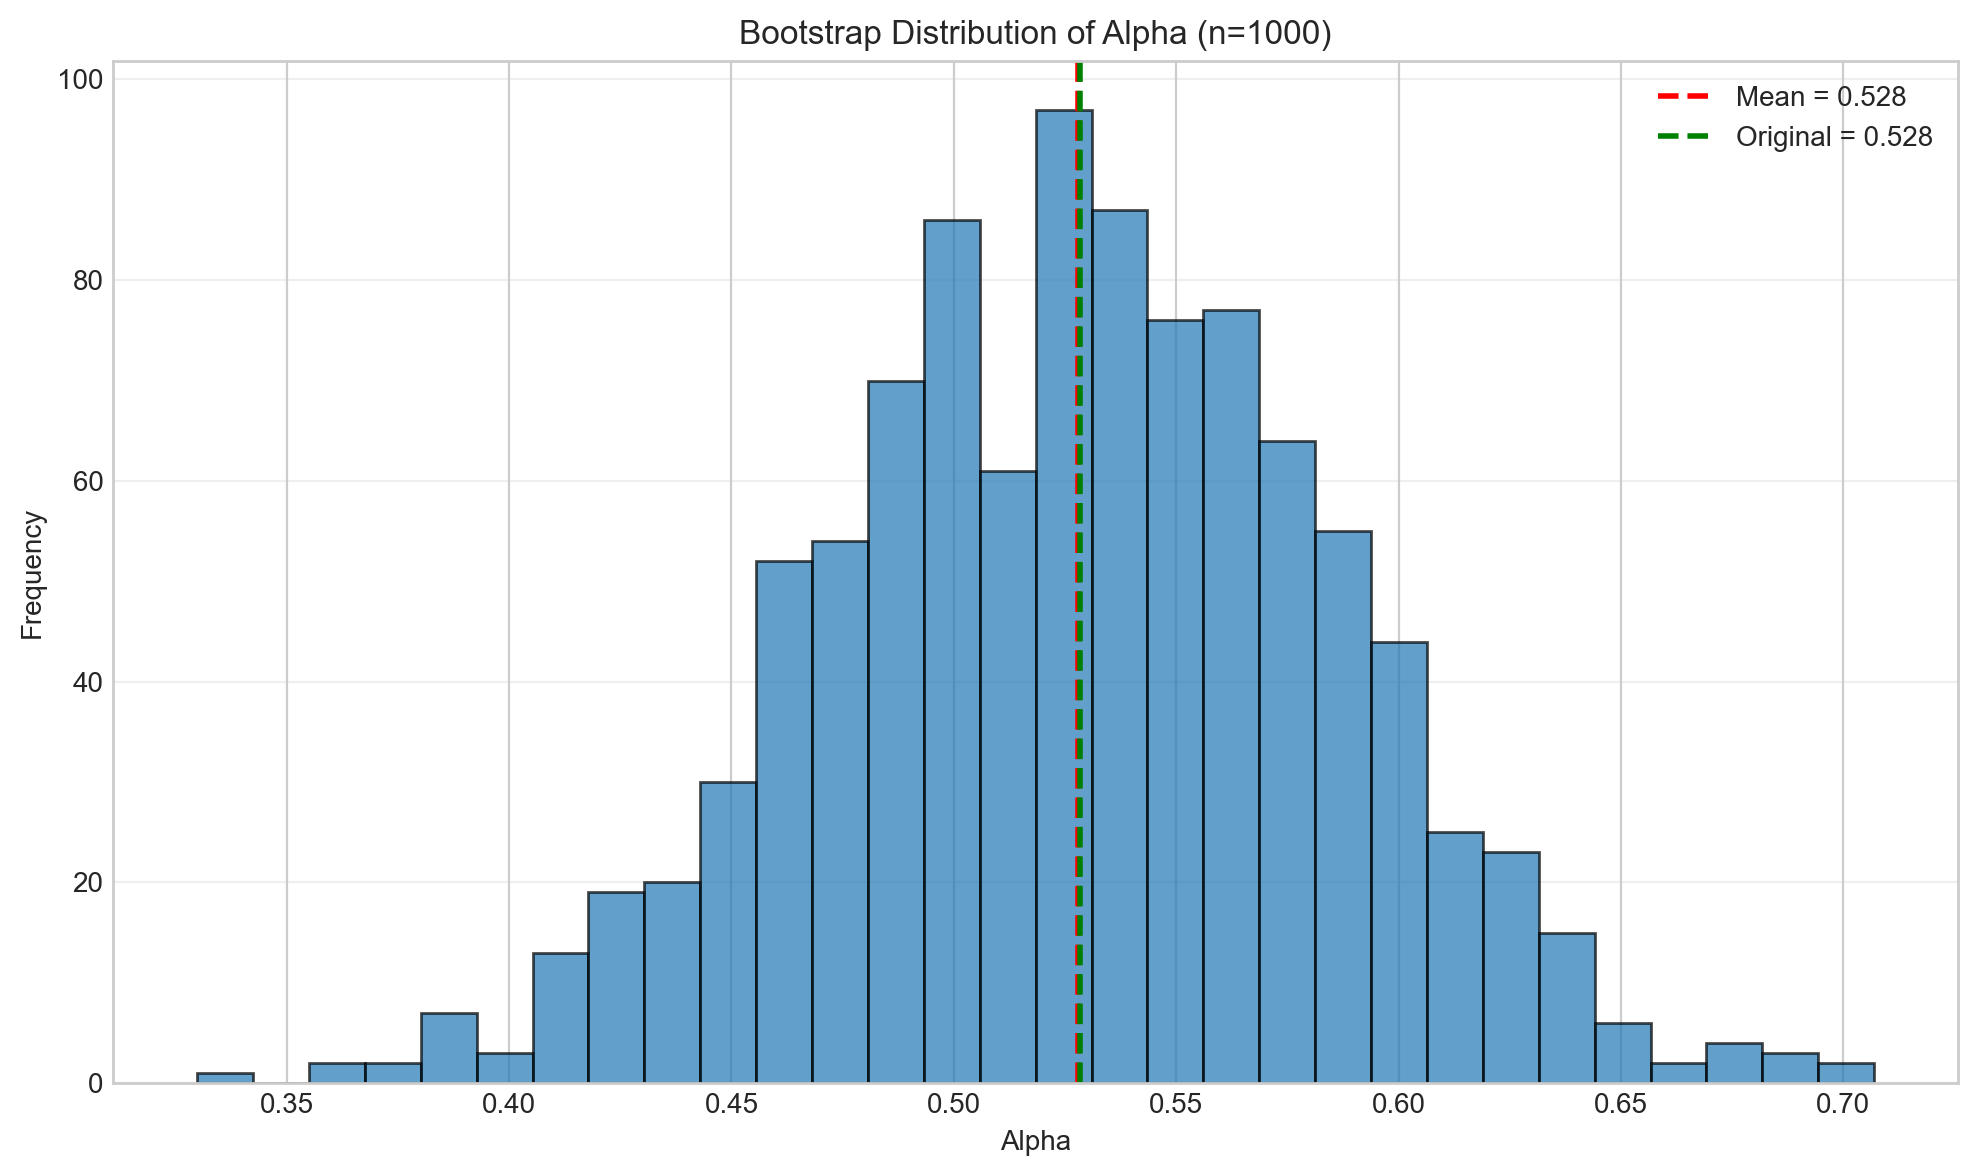

In [17]:
# Visualize bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(alpha_estimates, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(alpha_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {alpha_mean:.3f}')
plt.axvline(alpha_full, color='green', linestyle='--', linewidth=2, label=f'Original = {alpha_full:.3f}')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.title(f'Bootstrap Distribution of Alpha (n={n_bootstrap})')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. Bootstrap for Linear Regression Coefficients

Estimate uncertainty in regression coefficients using bootstrap.

In [18]:
# Function to estimate regression coefficients
def boot_fn_regression(data, indices):
    """
    Estimate regression coefficients: mpg ~ horsepower
    """
    data_boot = data.iloc[indices]
    X_boot = data_boot[['horsepower']]
    y_boot = data_boot['mpg']
    
    model = LinearRegression()
    model.fit(X_boot, y_boot)
    
    return [model.intercept_, model.coef_[0]]

# Estimate on full dataset
coef_full = boot_fn_regression(Auto, range(len(Auto)))
print(f"Coefficients (full dataset):")
print(f"Intercept: {coef_full[0]:.4f}")
print(f"Horsepower: {coef_full[1]:.4f}")

Coefficients (full dataset):
Intercept: 39.9359
Horsepower: -0.1578


In [19]:
# Bootstrap samples
np.random.seed(1)

print("\nBootstrap samples:")
for i in range(3):
    boot_indices = np.random.choice(len(Auto), size=len(Auto), replace=True)
    coefs = boot_fn_regression(Auto, boot_indices)
    print(f"Sample {i+1}: Intercept={coefs[0]:.4f}, Horsepower={coefs[1]:.4f}")


Bootstrap samples:
Sample 1: Intercept=39.6585, Horsepower=-0.1559
Sample 2: Intercept=40.7333, Horsepower=-0.1639
Sample 3: Intercept=41.8992, Horsepower=-0.1705


In [20]:
# Perform 1000 bootstrap replications
np.random.seed(1)
n_bootstrap = 1000
intercepts = []
slopes = []

for i in range(n_bootstrap):
    boot_indices = np.random.choice(len(Auto), size=len(Auto), replace=True)
    coefs = boot_fn_regression(Auto, boot_indices)
    intercepts.append(coefs[0])
    slopes.append(coefs[1])

intercepts = np.array(intercepts)
slopes = np.array(slopes)

# Bootstrap statistics
print("="*50)
print("BOOTSTRAP RESULTS FOR REGRESSION COEFFICIENTS")
print("="*50)
print(f"Intercept:")
print(f"  Original: {coef_full[0]:.4f}")
print(f"  Bootstrap mean: {np.mean(intercepts):.4f}")
print(f"  Bootstrap SE: {np.std(intercepts, ddof=1):.4f}")
print(f"\nHorsepower coefficient:")
print(f"  Original: {coef_full[1]:.4f}")
print(f"  Bootstrap mean: {np.mean(slopes):.4f}")
print(f"  Bootstrap SE: {np.std(slopes, ddof=1):.4f}")
print("="*50)

BOOTSTRAP RESULTS FOR REGRESSION COEFFICIENTS
Intercept:
  Original: 39.9359
  Bootstrap mean: 39.9634
  Bootstrap SE: 0.8257

Horsepower coefficient:
  Original: -0.1578
  Bootstrap mean: -0.1583
  Bootstrap SE: 0.0071


In [21]:
# Compare with standard formula SE
from scipy import stats
import statsmodels.api as sm

X_sm = sm.add_constant(Auto[['horsepower']])
model_sm = sm.OLS(Auto['mpg'], X_sm).fit()

print("\nComparison: Bootstrap vs Standard Formula")
print("="*50)
print(f"{'Coefficient':<15} {'Bootstrap SE':<15} {'Formula SE':<15}")
print("-"*50)
print(f"{'Intercept':<15} {np.std(intercepts, ddof=1):<15.4f} {model_sm.bse[0]:<15.4f}")
print(f"{'Horsepower':<15} {np.std(slopes, ddof=1):<15.4f} {model_sm.bse[1]:<15.4f}")
print("="*50)
print("\nNote: Bootstrap SE is often more accurate for non-normal errors")


Comparison: Bootstrap vs Standard Formula
Coefficient     Bootstrap SE    Formula SE     
--------------------------------------------------
Intercept       0.8257          0.7175         
Horsepower      0.0071          0.0064         

Note: Bootstrap SE is often more accurate for non-normal errors


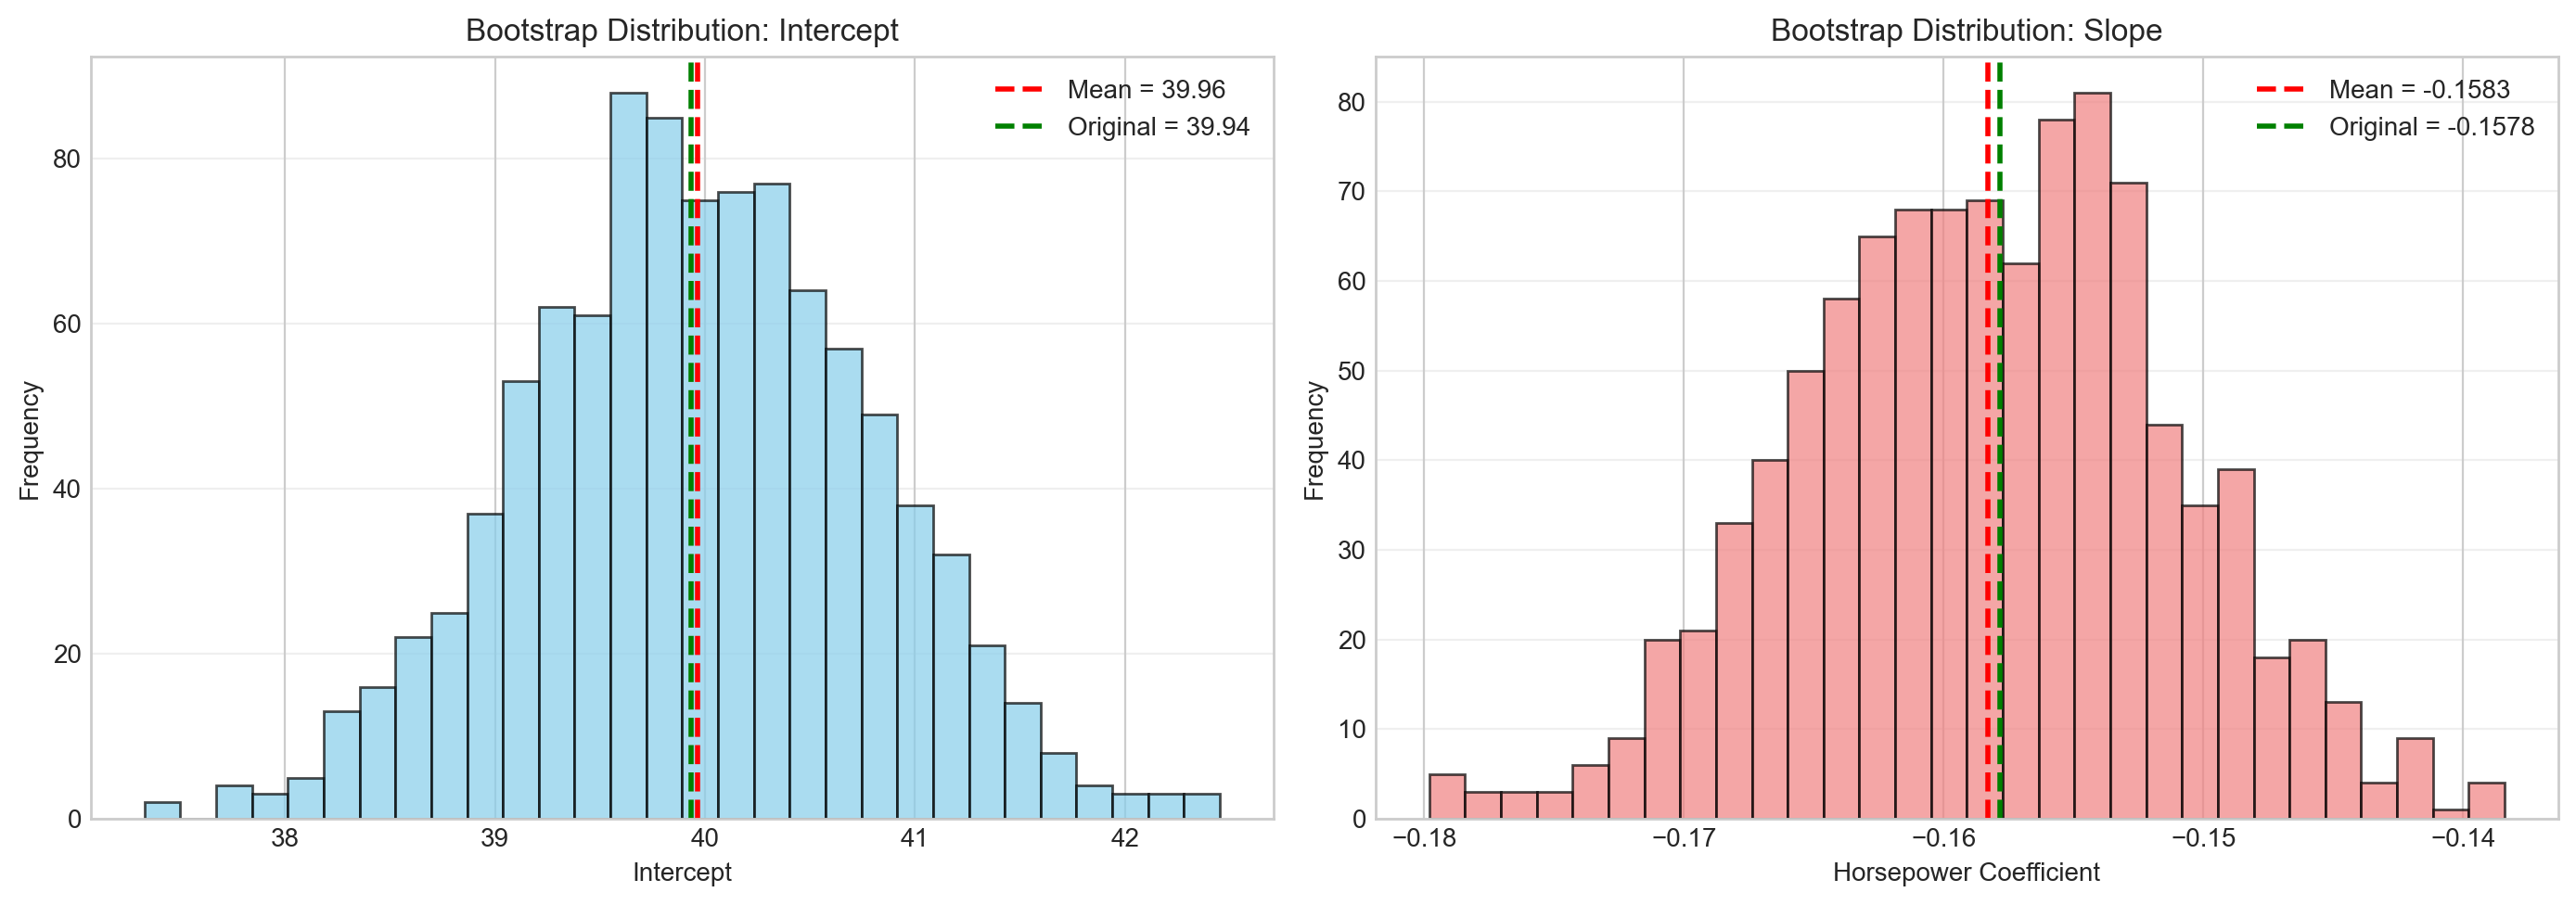

In [22]:
# Visualize bootstrap distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Intercept
axes[0].hist(intercepts, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(np.mean(intercepts), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {np.mean(intercepts):.2f}')
axes[0].axvline(coef_full[0], color='green', linestyle='--', linewidth=2, 
                label=f'Original = {coef_full[0]:.2f}')
axes[0].set_xlabel('Intercept')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Bootstrap Distribution: Intercept')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Slope
axes[1].hist(slopes, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].axvline(np.mean(slopes), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {np.mean(slopes):.4f}')
axes[1].axvline(coef_full[1], color='green', linestyle='--', linewidth=2, 
                label=f'Original = {coef_full[1]:.4f}')
axes[1].set_xlabel('Horsepower Coefficient')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Bootstrap Distribution: Slope')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Bootstrap for Quadratic Model

In [23]:
# Bootstrap for quadratic model: mpg ~ horsepower + horsepower^2
def boot_fn_quadratic(data, indices):
    data_boot = data.iloc[indices]
    X_boot = data_boot[['horsepower']]
    y_boot = data_boot['mpg']
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly_boot = poly.fit_transform(X_boot)
    
    model = LinearRegression()
    model.fit(X_poly_boot, y_boot)
    
    return [model.intercept_, model.coef_[0], model.coef_[1]]

# Full dataset
coef_quad_full = boot_fn_quadratic(Auto, range(len(Auto)))
print(f"Quadratic model coefficients (full dataset):")
print(f"Intercept: {coef_quad_full[0]:.4f}")
print(f"Horsepower: {coef_quad_full[1]:.4f}")
print(f"Horsepower²: {coef_quad_full[2]:.4f}")

Quadratic model coefficients (full dataset):
Intercept: 56.9001
Horsepower: -0.4662
Horsepower²: 0.0012


In [24]:
# Bootstrap for quadratic model
np.random.seed(1)
n_bootstrap = 1000
coef_quad_boot = []

for i in range(n_bootstrap):
    boot_indices = np.random.choice(len(Auto), size=len(Auto), replace=True)
    coefs = boot_fn_quadratic(Auto, boot_indices)
    coef_quad_boot.append(coefs)

coef_quad_boot = np.array(coef_quad_boot)

print("\n" + "="*50)
print("BOOTSTRAP RESULTS: QUADRATIC MODEL")
print("="*50)
print(f"{'Coefficient':<20} {'Bootstrap SE':<15}")
print("-"*50)
print(f"{'Intercept':<20} {np.std(coef_quad_boot[:, 0], ddof=1):<15.4f}")
print(f"{'Horsepower':<20} {np.std(coef_quad_boot[:, 1], ddof=1):<15.4f}")
print(f"{'Horsepower²':<20} {np.std(coef_quad_boot[:, 2], ddof=1):<15.4f}")
print("="*50)


BOOTSTRAP RESULTS: QUADRATIC MODEL
Coefficient          Bootstrap SE   
--------------------------------------------------
Intercept            2.1034         
Horsepower           0.0335         
Horsepower²          0.0001         


## Summary

This notebook covered:

### **Validation Set Approach**
- Simple train/test split
- Results depend on random split
- Uses only 50% of data for training

### **Leave-One-Out Cross-Validation (LOOCV)**
- Uses n-1 observations for training
- Less bias (more data for training)
- Computationally expensive (n iterations)
- Lower variance in error estimate

### **K-Fold Cross-Validation**
- Compromise between validation set and LOOCV
- K=10 is common choice
- Less computationally expensive than LOOCV
- Good bias-variance trade-off

### **Bootstrap**
- Resample data with replacement
- Estimate parameter uncertainty
- More accurate SE for non-normal errors
- Flexible: works for any statistic

### **Key Takeaways:**
- Cross-validation helps select model complexity
- LOOCV has low bias but high variance
- K-Fold CV (K=5 or 10) is a good default
- Bootstrap provides robust SE estimates
- Always validate on held-out data!